In [1]:
import get_rxnpair_info_copy
import zipfile
import pickle as pkl
from custom_chem import Atom, Bond, Molecule, Reaction
import json
from tqdm import tqdm
from rdkit import Chem

In [2]:
# old = "D:/ReactionCentersProject/data/figure_repo/figure_repo/data/KEGG_COMPOUNDS_KCF_parsed.zip"
# new = "D:/ReactionCentersProject/data/figure_repo/figure_repo/data/KEGG_COMPOUNDS_KCF_parsed_fixed.zip"
# with zipfile.ZipFile(old, "r") as zip_in, zipfile.ZipFile(new, "w") as zip_out:
#     for item in zip_in.infolist():
#         new_name = item.filename.replace(":", "_")
#         with zip_in.open(item.filename) as f:
#             zip_out.writestr(new_name, f.read())
#     

In [3]:
mappings_all_path = "D:/ReactionCentersProject/data/figure_repo/figure_repo/results/atom_mappings_KEGG_RCLASS.json"
reactions_all_path = "D:/ReactionCentersProject/data/figure_repo/figure_repo/results/KEGG_REACTIONS.json"
cpds_all_path = "D:/ReactionCentersProject/data/figure_repo/figure_repo/results/KEGGCpds/kcf_cpds_aromaticCurated"
kcf_path = "D:/ReactionCentersProject/data/figure_repo/figure_repo/data/KEGG_COMPOUNDS_KCF_parsed_fixed/kcf_parsed"
rclass_path = "D:/ReactionCentersProject/data/figure_repo/figure_repo/data/KEGG_RCLASS_fixed/raw"

In [4]:
#get_rxnpair_info_copy.main(mappings_all_path,reactions_all_path,cpds_all_path,kcf_path,rclass_path)

In [5]:
pkl_path = "rxn_pairs.pkl"
with open(pkl_path, 'rb') as f:
    data = pkl.load(f)

In [13]:
correct = 0
incorrect = 0
incorrects = []
for rid, rdata in tqdm((data.items()), total=len(data.items()), desc="Validating RDM algorithm"):
    _, id1, id2 = rid.split("_")
    mol1 = Molecule.from_kcf(kcf_path, id1)
    mol2 = Molecule.from_kcf(kcf_path, id2)

    used_nums = {atom.mapping_num for atom in mol1.graph}
    next_num = max(used_nums) + 1
    mapping_num_changes = {}

    idxL_to_atom = {a.mapping_num - 1: a for a in mol1.graph.keys()}
    idxR_to_atom = {a.mapping_num - 1: a for a in mol2.graph.keys()}

    for left_num, right_num in rdata["atom_mappings"].items():
        mapping_num_changes[right_num + 1] = left_num + 1

    for right_atom in mol2.graph.keys():
        if right_atom.mapping_num not in mapping_num_changes:
            mapping_num_changes[right_atom.mapping_num] = next_num
            used_nums.add(next_num)
            next_num = max(used_nums) + 1

    mol2.update_atom_map_num(mapping_num_changes)

    mol1 = Molecule.from_rdkit_mol(Molecule.to_rdkit_from_graph(mol1.graph))
    mol2 = Molecule.from_rdkit_mol(Molecule.to_rdkit_from_graph(mol2.graph))

    rxn = Reaction(mol1, mol2)
    reaction_centers, _, _ = rxn.get_rdm()

    if rdata["rxn_centers_count"] == len(reaction_centers):
        correct += 1
    else:
        incorrect += 1
        incorrects.append(rid)

print(correct / (correct + incorrect))


Validating RDM algorithm: 100%|██████████| 10212/10212 [00:36<00:00, 276.65it/s]

0.7703681942812377


Code below looks at specific examples of reactions where the custom algorithm got a different result from KEGG.


In [7]:
test = "RC00037_C04230_C00157"# incorrects[4]
test

'RC00037_C04230_C00157'

In [8]:
data[test]

{'reaction': 'R07859',
 'cpd_left': 'C04230',
 'cpd_right': 'C00157',
 'cpd_left_atom_count': 19,
 'cpd_right_atom_count': 22,
 'cpd_end': {'C00157', 'C04230'},
 'cpd_all': {'C00157', 'C04230'},
 'atom_mappings': {9: 0,
  5: 1,
  3: 5,
  1: 7,
  4: 9,
  0: 10,
  2: 13,
  6: 19,
  7: 20,
  8: 21,
  11: 2,
  13: 6,
  14: 8,
  15: 11,
  16: 14,
  17: 15,
  18: 16,
  12: 3,
  10: 4},
 'atom_mapping_count': 19,
 'atom_mapping_jaccard': 0.8636363636363636,
 'rclass_id': 'RC00037_C04230_C00157',
 'reversed_rclass_id': 'RC00037_C00157_C04230',
 'rxn_centers_count': 1,
 'rc_all': 'RC00037',
 'left_rcs': {'O1a': {'difference': [], 'mapped': ['C1c']}},
 'right_rcs': {'O7a': {'difference': ['C7a'], 'mapped': ['C1c']}},
 'rc_name_correspondence': {'O1a': 'O7a'},
 'rc_name_mappings': {'': 2, '4': 9}}

In [9]:
rid = test
_, id1, id2 = rid.split("_")
mol1 = Molecule.from_kcf(kcf_path, id1)
mol2 = Molecule.from_kcf(kcf_path, id2)

used_nums = {atom.mapping_num for atom in mol1.graph}
next_num = max(used_nums) + 1
mapping_num_changes = {}

idxL_to_atom = {a.mapping_num - 1: a for a in mol1.graph.keys()}
idxR_to_atom = {a.mapping_num - 1: a for a in mol2.graph.keys()}

for left_num, right_num in data[rid]["atom_mappings"].items():
    mapping_num_changes[right_num + 1] = left_num + 1

for right_atom in mol2.graph.keys():
    if right_atom.mapping_num not in mapping_num_changes:
        mapping_num_changes[right_atom.mapping_num] = next_num
        used_nums.add(next_num)
        next_num = max(used_nums) + 1

mol2.update_atom_map_num(mapping_num_changes)

mol1 = Molecule.from_rdkit_mol(Molecule.to_rdkit_from_graph(mol1.graph))
mol2 = Molecule.from_rdkit_mol(Molecule.to_rdkit_from_graph(mol2.graph))

rxn = Reaction(mol1, mol2)
reaction_centers, _, _ = rxn.get_rdm()
print(reaction_centers)
print("----")


[Atom(mapping_num=5, symbol='O', charge=0), Atom(mapping_num=13, symbol='O', charge=0)]
----


In [10]:
data[rid]

{'reaction': 'R07859',
 'cpd_left': 'C04230',
 'cpd_right': 'C00157',
 'cpd_left_atom_count': 19,
 'cpd_right_atom_count': 22,
 'cpd_end': {'C00157', 'C04230'},
 'cpd_all': {'C00157', 'C04230'},
 'atom_mappings': {9: 0,
  5: 1,
  3: 5,
  1: 7,
  4: 9,
  0: 10,
  2: 13,
  6: 19,
  7: 20,
  8: 21,
  11: 2,
  13: 6,
  14: 8,
  15: 11,
  16: 14,
  17: 15,
  18: 16,
  12: 3,
  10: 4},
 'atom_mapping_count': 19,
 'atom_mapping_jaccard': 0.8636363636363636,
 'rclass_id': 'RC00037_C04230_C00157',
 'reversed_rclass_id': 'RC00037_C00157_C04230',
 'rxn_centers_count': 1,
 'rc_all': 'RC00037',
 'left_rcs': {'O1a': {'difference': [], 'mapped': ['C1c']}},
 'right_rcs': {'O7a': {'difference': ['C7a'], 'mapped': ['C1c']}},
 'rc_name_correspondence': {'O1a': 'O7a'},
 'rc_name_mappings': {'': 2, '4': 9}}

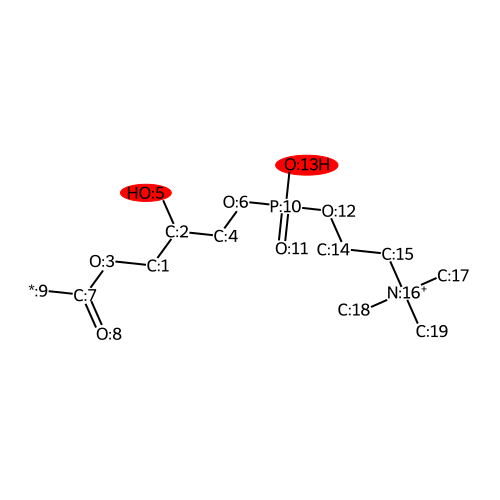

In [11]:
img = rxn.get_images()[0]
display(img)

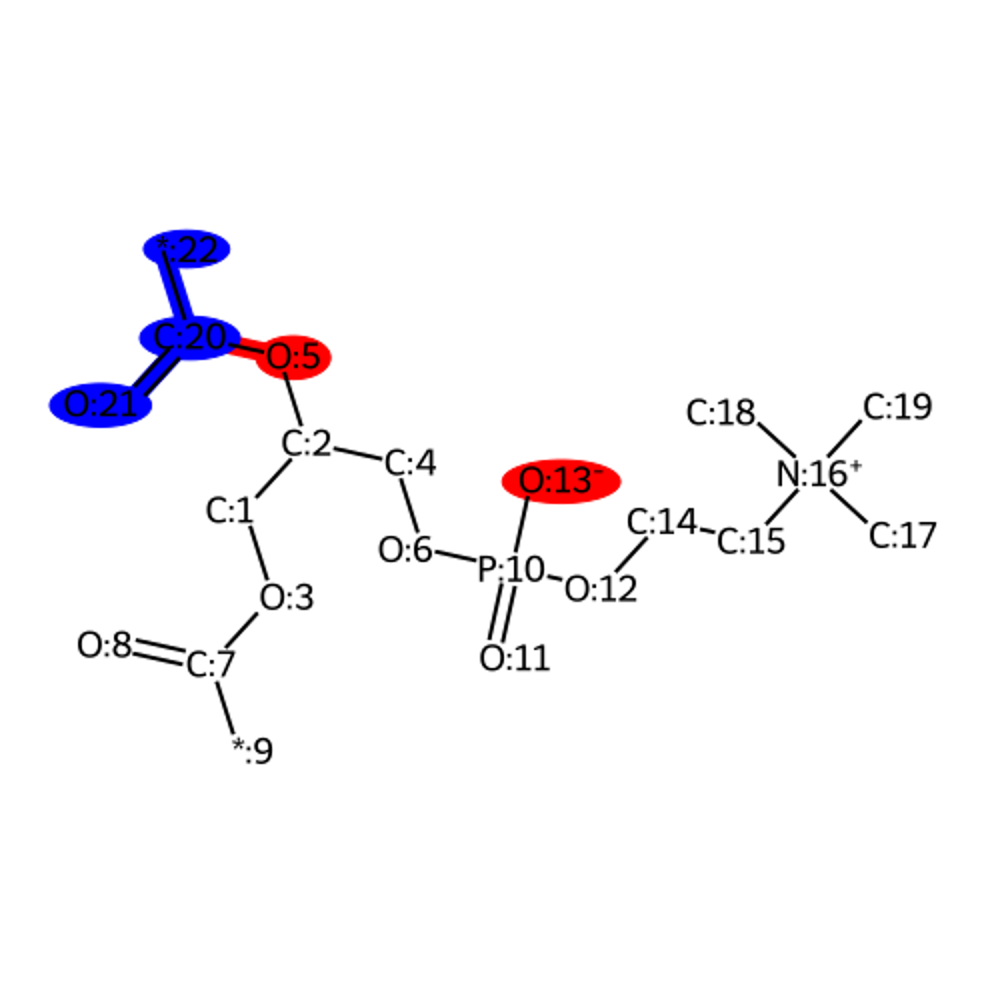

In [12]:
img = rxn.get_images()[1]
img = img.resize((img.width * 2, img.height * 2))
display(img)

In [ ]:
rxn.reactants[0].graph

In [ ]:
rxn.products[0].graph

In [21]:
img = rxn.get_images()


KeyError: 1